In [ ]:
%matplotlib inline
import nibabel
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from ipywidgets import interact, widget, IntSlider
from skimage import measure
from tqdm import tqdm

In [ ]:
maindir = "C:\\Users\simon\Documents\EPFL\Master\Semestre5\Projet MIPLAB\Data_2016_T2_TRACE_LESION"
lesion_files = []
t2_files = []
for patient in tqdm(os.listdir(maindir)):
    if "excluded" in patient:
        continue
    folderpath = os.listdir(os.path.join(maindir,patient))[0]
    folderpath = os.path.join(maindir,patient,folderpath)
    lesion = [os.path.join(folderpath,x) for x in os.listdir(folderpath) if x.startswith("rcoreg") and ("VOI") in x][0]
    t2 = [os.path.join(folderpath,x) for x in os.listdir(folderpath) if x.startswith("rcoreg") and ("TRACE") in x][0]
    lesion_files.append(lesion)
    t2_files.append(t2)
    
#check integrity
assert(len(t2_files)==len(lesion_files))
brain_file = t2_files[0]

# Load data of patients
list_lesion_data = []
for file in lesion_files:
    x = nibabel.load(file).get_data()
    list_lesion_data.append(x)
numpy_lesions = np.array(list_lesion_data)

# Load a reference MRI coregistrated scan
T2 = nibabel.load(brain_file).get_data()

print("Number of patients : {}".format(len(lesion_files)))

The dataset contains 55 valid patients (scan can be coregistrated).

In [ ]:
layer = 12
index = 4
brain_file = t2_files[index]
lesion_file = lesion_files[index]
one_t2 = nibabel.load(brain_file).get_data()
one_lesion = nibabel.load(lesion_file).get_data()
plt.imshow(one_t2[:,:,layer])
plt.show()
plt.imshow(one_lesion[:,:,layer])

## Location of lesions

In [4]:
s = np.sum(numpy_lesions,axis=0)
voxel_size = [np.sum(x) for x in numpy_lesions]

merged_image = np.empty(shape=(s.shape[0], s.shape[1], s.shape[2],3))
merged_image[:,:,:,0] = (s/np.max(s))
merged_image[:,:,:,2] = (T2/np.max(T2))

In [5]:
def plot_lesion_heatmap(layer):
    ax = plt.figure(figsize=[10,10])
    plt.imshow((merged_image[:,:,layer,:]* 255).astype(np.uint8))
    plt.title("Sum of lesion locations",fontsize=20)
    norm = colors.Normalize(vmin=0, vmax=np.max(s))
    
    #Create colormap
    C = np.array([(x,0,0) for x in range(255)]) # Black to red, linear
    cm = colors.ListedColormap(C/255.0)
    sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
    sm.set_array([])
    plt.colorbar(sm,fraction=0.0385, pad=0.04)

In [6]:
interactive_plot = interact(plot_lesion_heatmap, layer=IntSlider(min=0,max=s.shape[2]-1,step=1,value=40))

interactive(children=(IntSlider(value=31, description='layer', max=31), Output()), _dom_classes=('widget-interact',))

We can observe that the dataset is imbalanced, with about 30% of the patient that have a lesion in the right 

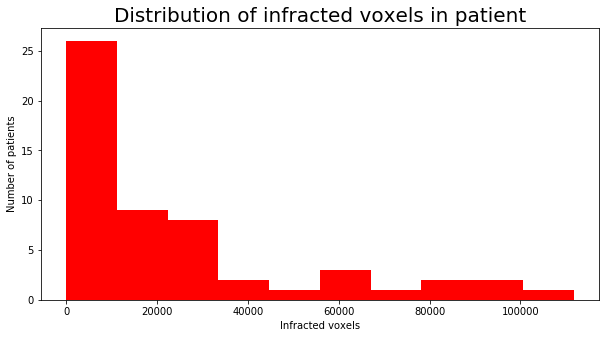

In [7]:
plt.figure(figsize=(10,5))
plt.hist(voxel_size,color="r")
plt.title("Distribution of infracted voxels in patient",size=20)
plt.xlabel("Infracted voxels")
plt.ylabel("Number of patients")
plt.show()

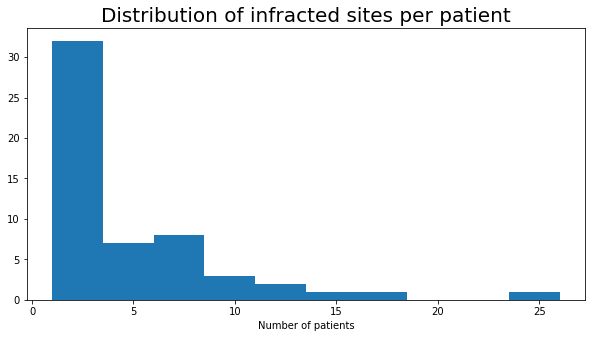

In [8]:
number_lesions = [np.max(measure.label(x, background=0)) for x in list_lesion_data]
plt.figure(figsize=[10,5])
plt.hist(number_lesions)
plt.title("Distribution of infracted sites per patient",size=20)
plt.xlabel("Number of infracted sites")
plt.xlabel("Number of patients")
plt.show()

## Numerical analysis of Input Data

In [9]:
def normalize(img):
    mean = np.mean(img)
    std = np.std(img)
    return (img-mean)/std

In [10]:
from tqdm import tqdm
normalized_imgs = []
lesions_data = []
non_lesion_data = []

for file in tqdm(t2_files):
    lesion_file = file.replace("t2_tse_tra","VOI_lesion")
    x = nibabel.load(file).get_data()
    y = nibabel.load(lesion_file).get_data()
    img = normalize(x)
    
    # get indices where lesion=1
    lesion = img[np.where(y==1)]
    non_lesion = img[np.where(y==0)]
    
    img = list(img.flatten())
    
    normalized_imgs.append(img)
    lesions_data.append(lesion)
    non_lesion_data.append(non_lesion)

100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [01:58<00:00,  2.15s/it]


C:\Users\simon\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\Users\simon\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1856: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
C:\Users\simon\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1863: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)
C:\Users\simon\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1871: RuntimeWarning: invalid value encountered in less
  np.compress(x < stats['whislo'], x),
C:\Users\simon\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1872: RuntimeWarning: invalid value encountered in greater
  np.compress(x > stats['whishi'], x)


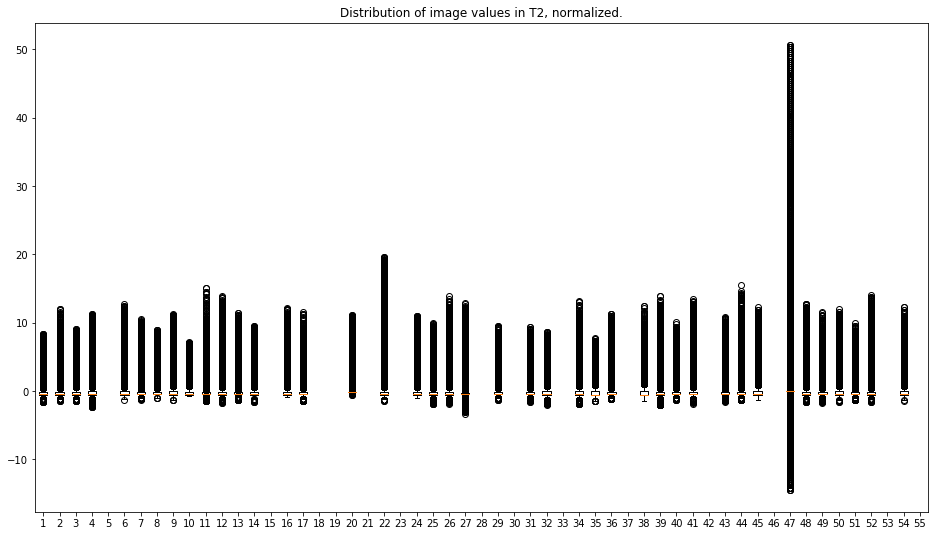

In [11]:
plt.figure(figsize=[16,9])
plt.boxplot(normalized_imgs)
plt.title("Distribution of image values in T2, normalized.")
plt.show()

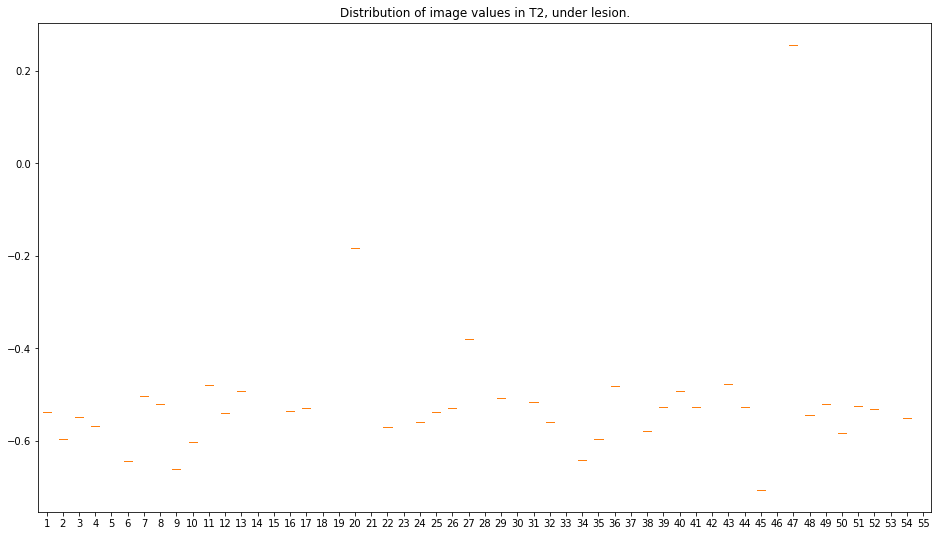

In [12]:
plt.figure(figsize=[16,9])
plt.boxplot(lesions_data)
plt.title("Distribution of image values in T2, under lesion.")
plt.show()

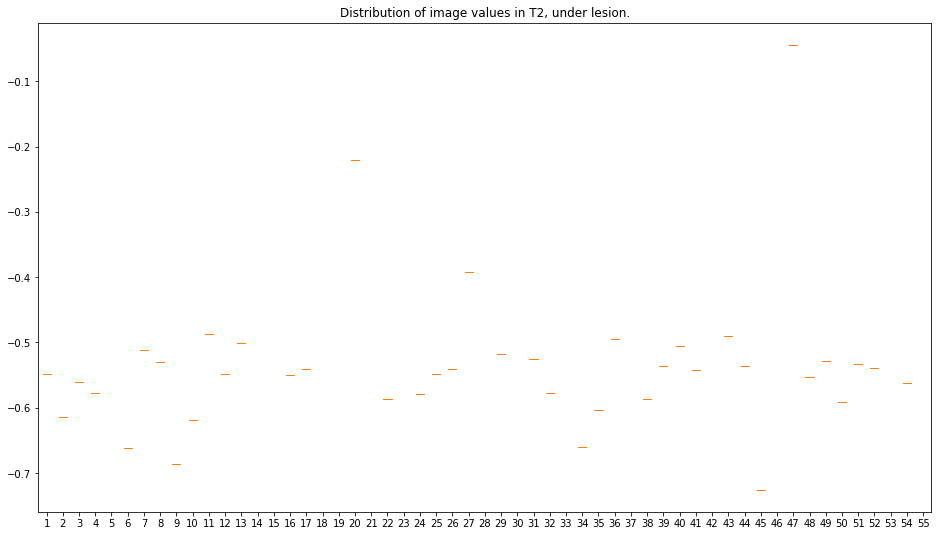

In [13]:
plt.figure(figsize=[16,9])
plt.boxplot(non_lesion_data)
plt.title("Distribution of image values in T2, under lesion.")
plt.show()